In [1]:
import numpy as np
import scipy as sp
from scipy import signal
import sklearn as sk
from sklearn import neighbors
import preprocessing as pp
import utilities as u
from matplotlib import pyplot as plt
import pickle
import os

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
def gaussian(mu,sigma,x):
    '''radial basis function centered at 'mu' with width 'sigma', sampled at 'x' '''
    return np.exp(-(mu-x)**2/sigma**2)

getf = lambda s : s*2.5 + (1-s)*3.5
gettheta = lambda s: (s*60. + (1-s)*10.)*np.pi/180
xfreq = lambda s: np.abs(getf(s)*1500/120*(np.cos(gettheta(s) + np.pi/4.)-np.sin(gettheta(s)+np.pi/4.))) 
yfreq = lambda s: np.abs(getf(s)*1500/120*(np.cos(gettheta(s) + np.pi/4.)+np.sin(gettheta(s)+np.pi/4.))) 
ang = lambda x,y: np.arctan(x/y)*180/np.pi

wallmorphx = lambda s: 1.2*(xfreq(s)-xfreq(-.1))/(xfreq(1.1)-xfreq(-.1))-.1
wallmorphy = lambda s: 1.2*(yfreq(s)-yfreq(-.1))/(yfreq(1.1)-yfreq(-.1))-.1

In [3]:
df = pp.load_session_db(dir='D:\\')
# df = pp.load_session_db()
df = df[df['RewardCount']>40]
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
df = df[df["Track"]=="TwoTower_foraging"]

In [4]:
# load sf regression info for priors
with open("D:\\Morph_Results\\rare_sf_regression.pkl",'rb') as f:
    rare_sfreg = pickle.load(f)
    
with open("D:\\Morph_Results\\freq_sf_regression.pkl",'rb') as f:
    freq_sfreg = pickle.load(f)

In [256]:
def mean_prior_post(dict_sfreg,sigma_likelihood=.3,x=np.linspace(-.1,1.1,num=1000)[np.newaxis,:]):
    mice = [mouse for mouse in dict_sfreg.keys()]
    priors = np.zeros([len(mice),x.shape[1]])
    for i, (mouse,res) in enumerate(dict_sfreg.items()):
        _prior=None
        for _p in res['priors']:
            if _prior is None:
                _prior = _p
            else:
                _prior+=_p
        _prior = _prior/_prior.sum()
        priors[i,:]=_prior
        
    prior = _prior.mean(axis=0,keepdims=True)
    prior = prior/prior.sum()
    post = prior*gaussian(np.linspace(-.11,1.11,num=1000)[:,np.newaxis],sigma_likelihood,np.linspace(-.3,1.3,num=1000)[np.newaxis,:])
    post = post/post.sum(axis=1)
    return priors, prior, post
rare_priors,rare_prior,rare_post = mean_prior_post(rare_sfreg)
freq_priors,freq_prior,freq_post = mean_prior_post(freq_sfreg)

In [251]:
# load example session data
mouse = '4222174.1'
df_mouse = df[df["MouseName"]==mouse]

sess = df_mouse.iloc[-1]

In [252]:
with open(os.path.join("D:\\Suite2P_Data\\",sess["MouseName"],"%s_%s_%i.pkl" % (sess["Track"],sess["DateFolder"],sess["SessionNumber"])),'rb') as f:
    data = pickle.load(f)
print(data.keys())
S, tstart_inds, teleport_inds,VRDat = np.copy(data["S"]), data["tstart_inds"], data["teleport_inds"],data["VRDat"]
S[np.isnan(S)]=0
print(np.isnan(S).sum())
S = S/np.percentile(S,95,axis=0,keepdims=True)
S_trial_mat = u.make_pos_bin_trial_matrices(np.copy(S),data['VRDat']['pos']._values,tstart_inds,
                                            teleport_inds,bin_size=10,mat_only=True)
trial_info = data['trial_info']
morphs = trial_info['morphs']+trial_info['wallJitter']
morphsort = np.argsort(morphs)
morphs = morphs[morphsort]

S_trial_mat = S_trial_mat[morphsort,:,:]
S_trial_mat = sp.ndimage.filters.gaussian_filter1d(S_trial_mat,2,axis=1)
S_trial_mat[np.isnan(S_trial_mat)]=0
S_tmat = S_trial_mat.reshape(S_trial_mat.shape[0],-1)
S_tmat_norm = S_tmat/(np.linalg.norm(S_tmat,axis=1,ord=2,keepdims=True)+1E-8)

dict_keys(['VRDat', 'C', 'S', 'dFF', 'trial_info', 'tstart_inds', 'teleport_inds', 'S_trial_mat', 'occ_trial_mat', 'edges', 'centers'])
0


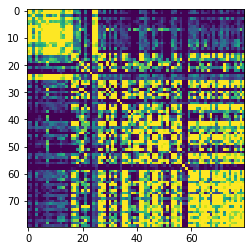

In [253]:
f,ax = plt.subplots()
simmat = np.dot(S_tmat_norm,S_tmat_norm.T)
ax.imshow(simmat,vmin=np.percentile(simmat,20),vmax=np.percentile(simmat,80))

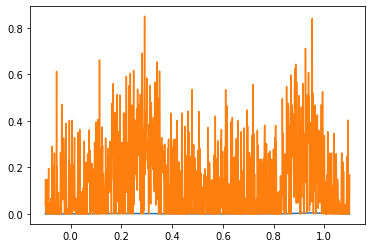

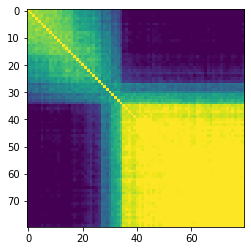

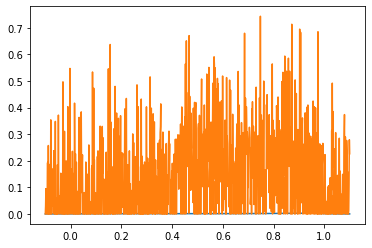

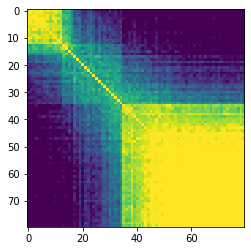

In [287]:
# calculate posterior 
for prior in [rare_prior,freq_prior]:
    xx = np.linspace(-.1,1.1,num=1000)
    f,ax = plt.subplots()
    ax.plot(xx,prior.ravel())
    post = prior*gaussian(wallmorphx(morphs[:,np.newaxis]),.3,xx[np.newaxis,:])

#     post += np.random.randn(*post.shape)
    post = post/post.sum(axis=1,keepdims=True)*100
#     post += .1*np.random.randn(*post.shape)
    post = np.maximum(post+.2*np.random.randn(*post.shape),0)
    ax.plot(xx,post[30,:].ravel())

    post_norm = post/np.linalg.norm(post,axis=1,ord=2,keepdims=True)

    post_sm = np.dot(post_norm,post_norm.T)
    f,ax = plt.subplots()
    ax.imshow(post_sm,vmin=np.percentile(post_sm,20),vmax=np.percentile(post_sm,80))